# In Depth Discussion of the Business Prototyping Toolkit for Python

The Business Prototyping Toolkit for Python comes with a model simulator and some methods to plot simulation results, a so-called API. Furthermore you may reuse the simulation results as DataFrames.

The API for plotting simulation is really simple. It only exposes some methods that generate plots. The simulations run in the background every time you call a plot method. For long and large simulations, please bear with me and bring a few seconds of patience before I plot. ;-) We try to optimize the simulation execution as much as possible but it may still take a while to generate results.

All simulation scenarios have to be in the ``scenarios/`` folder. BPTK_Py will scan and load them - including the models - into python. Each API method comes with many parameters for modifying the graph. The standard settings however are in my config. They define the common "transentis" style.

Usually you only need the ``scenario_names`` and ``equations`` parameters to get a working example. Of course you will probably want to define a title and labels for the x and y axis. Just look at the example method calls given to get a feel for the optional parameters.

This document is designed to help you understand all methods of the API quickly.

It is based on a simple Project Management model. We describe its equations and background in our [Blog Post](https://www.transentis.com/step-by-step-tutorials/introduction-to-system-dynamics/system-dynamics-simulation/). But you don't really need to understand the model to follow this document.

So let's get started now.

Before plotting, we have to setup some stuff.

Please run the following lines to import the API to your notebook and ignore the warnings (if any). You run a line by pushing ``Shift + Enter``

You will also get an overview over the available scenario managers and scenarios.


In [17]:
## BPTK Package
from BPTK_Py.bptk import bptk 

bptk = bptk()


print("Available Scenario Managers and Scenarios:")
print()
managers = bptk.scenario_manager_factory.get_scenario_managers(scenario_managers_to_filter=[])

for key, manager in managers.items():
     print("")
     print("*** {} ***".format(key))

     for name in manager.get_scenario_names():
         print("\t {}".format(name))



Available Scenario Managers and Scenarios:


*** anotherSimpleProjectManagement ***
	 scenario100
	 scenario80
	 scenario120

*** smSimpleProjectManagement ***
	 base
	 scenario100
	 scenario80
	 scenario120

*** smInteractive ***
	 scenario100

*** smSimpleProjectManagementV0 ***
	 base
	 scenario100
	 scenario80
	 scenario120


## Example 1: Multiple Equations for one scenario
Let's dive right in to the first the example. We may want to simulate different equations -  or variables in stela architect - for a specific simulation scenario. A scenario has a name and defines overrides for the simulation model's constants. Furthermore it supports the definition of strategies, which we will talk about a little later.

Let us simulate the equation 'openTasks' and 'closedTasks' for the scenario "scenario80". Play around with the parameters for the x/y labels and title.

You may either use the ``scenario_managers`` parameter and supply a list of all scenario Managers (by name) you want to plot the simulation results for. Or you use the specific ``scenario_name``. You may of course as well use both if you have duplicate names (one name in multiple scenario managers).

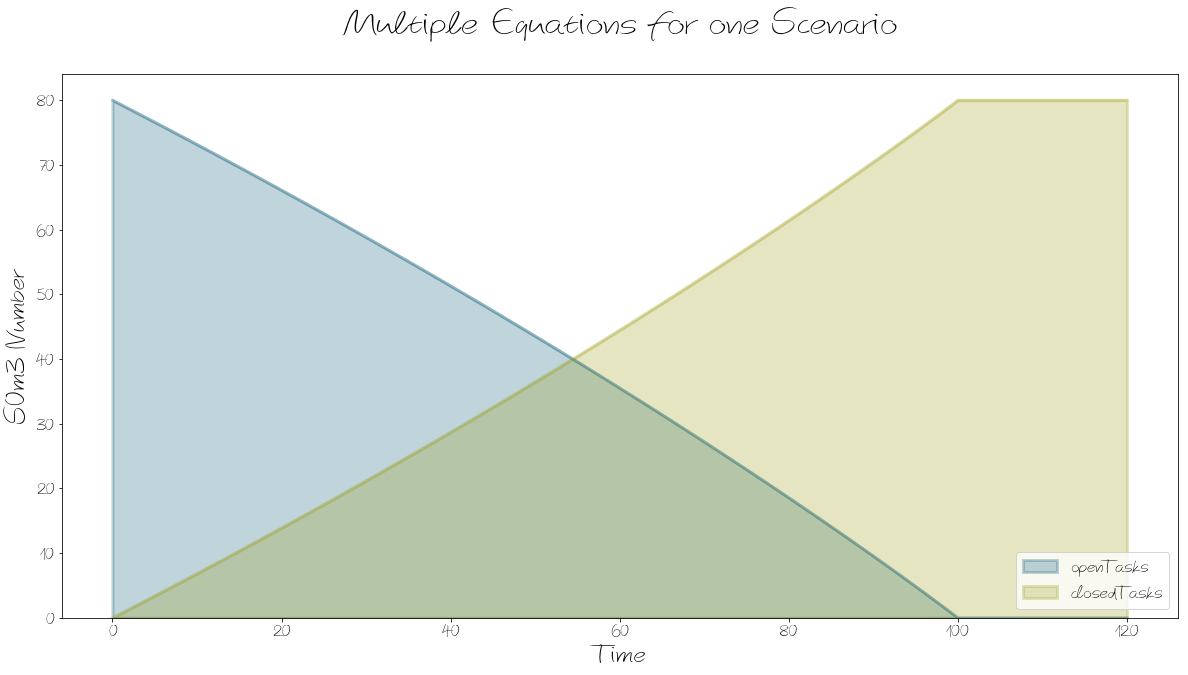

In [2]:

bptk.plot_scenarios(
    scenario_managers=["smSimpleProjectManagement"],
    scenarios=["scenario80"],
    equations=['openTasks',"closedTasks"],
    title="Multiple Equations for one Scenario\n",
    x_label="Time",
    y_label="S0m3 Number",
)


### Play with start date and frequency
In the above example, we did not specify the ``freq`` and ``start_date`` parameters. So the series just plots the values of t for the x axis. Using the mentioned parameters you can generate time series data. Let us set ``freq="M"``and ``start_date="1/11/2017"``.
Of course, the graph is the same. But the y-axis changed. Now the plot assumes daily data, starting at Nov, 1, 2017!

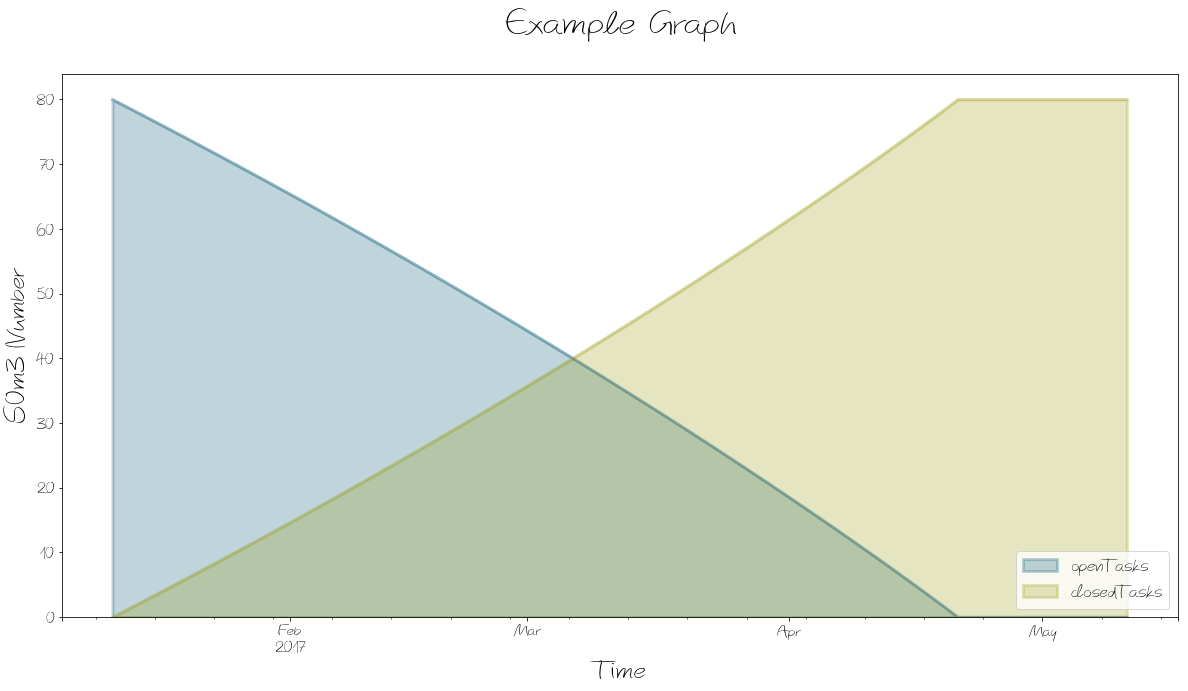

In [3]:

bptk.plot_scenarios(
    scenario_managers=["smSimpleProjectManagement"],
    scenarios=["scenario80"],
    equations=['openTasks',"closedTasks"],
    title="Example Graph\n",
    x_label="Time",
    y_label="S0m3 Number",
    start_date="1/11/2017",
    freq="D"
)

### Naming the series
The equation names are not the kind of names we want to show the customer. So let use the ``series_names`` parameter to rename them. Supply the equations to rename and their destination names. Use Python's dict notation: ``{ equation_name : rename_to }``. 

The dictionary serves as a set of replacement rules. To correctly rename the series, you have to understand how the framework sets the names of series to avoid ambiguity in series names. If you use more than one scenario manager for plotting, bptk_py will use the following series naming schema: ``"scenarioManager"_"scenario"_"equation"``. If you want to replace this, use ``series_names={"scenarioManager_scenario_equation": "new name"}``. You may as well define a rule that replaces the name of each scenario Manager with a whitespace. The number of rules is not limited.

Execute the following cell and see how we rename the series:


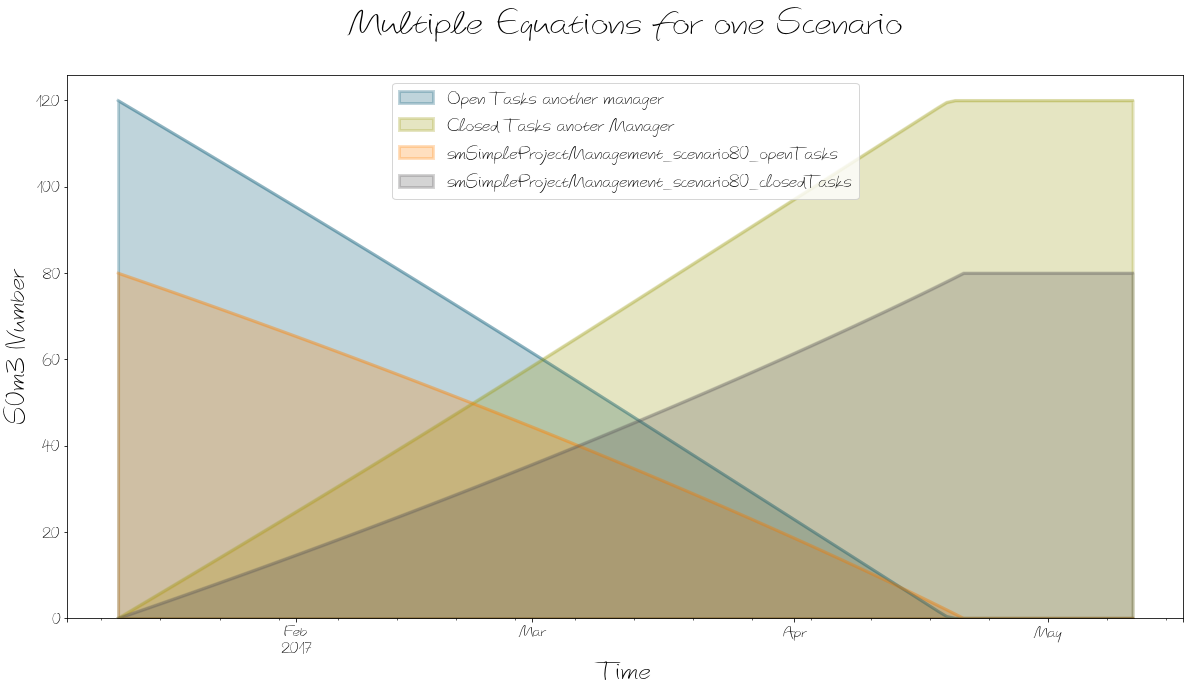

In [4]:
bptk.plot_scenarios(
    scenario_managers=["smSimpleProjectManagement","anotherSimpleProjectManagement"],
    scenarios=["scenario80"],
    equations=['openTasks',"closedTasks"],
    title="Multiple Equations for one Scenario\n",
    x_label="Time",
    y_label="S0m3 Number",
    start_date="1/11/2017",
    freq="D",
    series_names={"anotherSimpleProjectManagement_scenario80_openTasks" : "Open Tasks another manager" , "anotherSimpleProjectManagement_scenario80_closedTasks" : "Closed Tasks anoter Manager",}
)

## Example 2: Plot one equation for multiple scenarios
Now let us change the perspective. In the above example we assumed one scenario for which we simulate multiple equations. Now we simulate **one equation for multiple scenarios**.
The parameters stay the same and you can play around with them just as you could above. As you may have guessed already, You may even use multiple scenarios **and** equations. The framework will make sure that the naming is still fine.

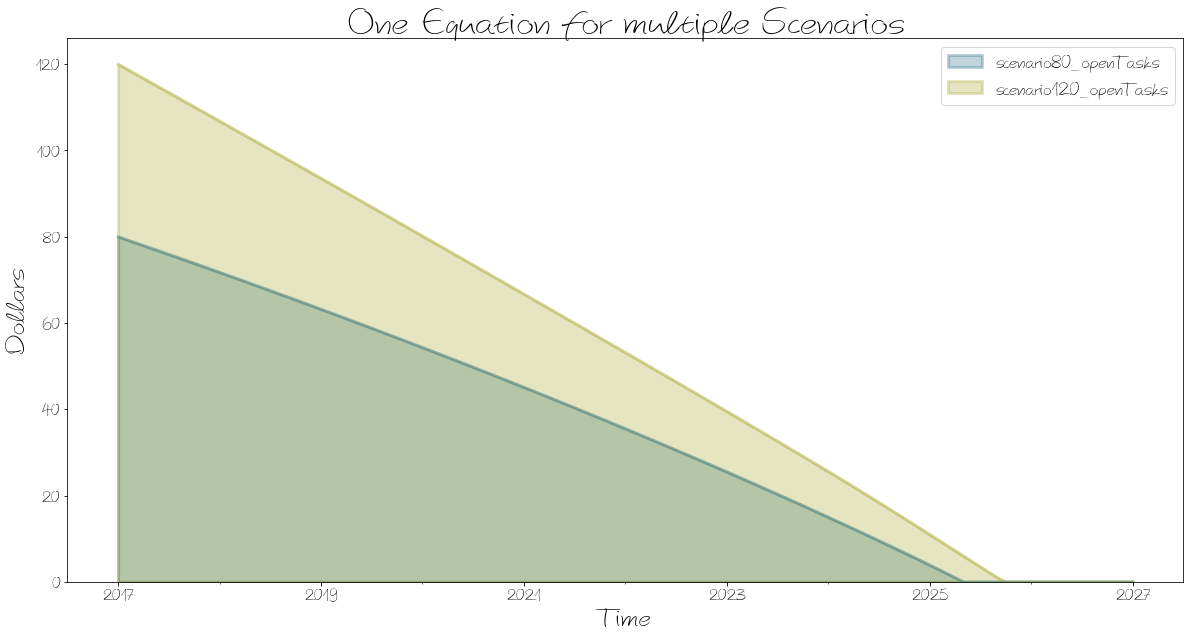

In [5]:
bptk.plot_scenarios(
    scenario_managers=["smSimpleProjectManagement"],
    scenarios=["scenario80","scenario120"],
    equations=["openTasks"],
    stacked=False, 
    freq="M", 
    start_date="1/11/2017",
    title="One Equation for multiple Scenarios",
    x_label="Time",
    y_label="Dollars",

)

## What if I want another kind of graph?
Well, there is the ``kind`` parameter! Let us see what happens if we set ``kind="line"``!


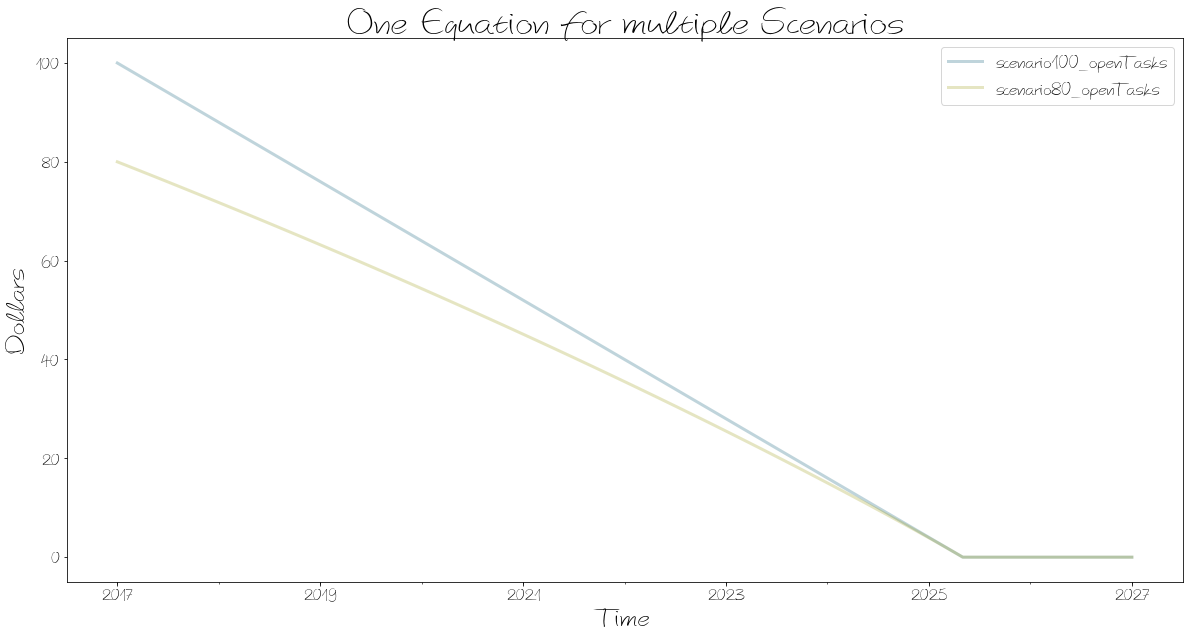

In [6]:
bptk.plot_scenarios(
    scenario_managers=["smSimpleProjectManagement"],
    scenarios=["scenario100","scenario80"],
    equations=["openTasks"],
    stacked=False, 
    freq="M", 
    start_date="1/11/2017",
    title="One Equation for multiple Scenarios",
    x_label="Time",
    y_label="Dollars",
    kind="line"
)

## Interactive Plotting
An important part of modelling is to modify values on-the-fly, interactively with the customer. The API call ``bptk.dashboard`` has this functionality. It comes with a field "constants" that contains a list of widget definitions. Each widget is defined using a tuple.
The structure is:  ``("widget_type","name.of.constant",start_value,maximum_value)``. This allows you to see the results of the simulations instantly without having to re-run the simulation manually. See a working example in the following plot.

Currently, we support two types of widgets to control the process:
* **sliders**: Sliders allow you to select a value in an interval. Use "slider" as ``widget_type``. A slider requires ``start_value and maximum_value`` as described above. Example: ``("slider",'initialOpenTasks',100.0,1000.0)``
* **checkbox**: If you want a checkbox, use "checkbox" as ``widget_type``. You do not have to supply ``start_value / maximum_value``. Example: ``("checkbox","initialStaff")``
* **timerange**: This will give you a slider in which you can select time intervals within the graph to "zoom in/out" of certain parts of the graph. It gives you the power to further look into certain simulation periods. It is enough to just add the keyword "timerange" as ``widget_type``.

For interactive plotting to work, you need to install an extension to jupyter lab. If you followed the above guide for initial setup, this should do in the terminal:
```
source venv/bin/activate
jupyter labextension install @jupyter-widgets/jupyterlab-manager
```

### Model modifications by dashboard widgets

It is important to mention that everytime you move a slider/checkbox, the underlying model equations are modified. This means, the results of the scenario will also deviate in other plots of the same scenario. You may reuse the modifications to the model in further plots. If this is not what you want,
a quick workaround is to initiliaze another instance of BPTK_Py and run the ``dashboard`` function independently from the other instance(s).

#### Attention Mac OS X user
There is a bug in the underlying NPM framework that requires you to use node version 8 to successfully download the extension. If you are using homebrew, issue these commands:
```
brew install node@8

#before calling the code above prepend node@8 to the path:

source venv/bin/activate
export PATH='/usr/local/opt/node@8/bin:$PATH'
jupyter labextension install @jupyter-widgets/jupyterlab-manager
```

In [20]:

bptk.dashboard(scenario_managers=["smInteractive"],
                                scenarios=["scenario100"],
                                kind="area",
                                equations=['openTasks',"closedTasks"],
                                stacked=False,
                                strategy=False,
                                freq="D",
                                start_date="1/11/2017",
                                title="Interactive Plotting",
                                x_label="Date",
                                y_label="€",
                                constants=[("slider",'deadline',0.0,1000.0),("slider","effortPerTask",0.1,1.0),("timerange")]
                                )


interactive(children=(FloatSlider(value=500.0, continuous_update=False, description='deadline', layout=Layout(…

In [8]:
bptk.reset_all_scenarios()

{'anotherSimpleProjectManagement': <BPTK_Py.scenariomanager.scenario_manager.scenarioManager at 0x11b413a58>,
 'smSimpleProjectManagement': <BPTK_Py.scenariomanager.scenario_manager.scenarioManager at 0x11b41afd0>,
 'smInteractive': <BPTK_Py.scenariomanager.scenario_manager.scenarioManager at 0x11b010358>,
 'smSimpleProjectManagementV0': <BPTK_Py.scenariomanager.scenario_manager.scenarioManager at 0x11b010be0>}

## Strategies

The simulator is also able to simulate various strategies. A strategy defines which constants change at which point in time of the simulation. For defining a strategy, use the ``strategy`` key in your scenario definition and give (key,value) sets for the constants you'd like to change. Note that the ``constants`` field in the strategy will also be parsed at ``t=0`` for initial modifications of the strategies.
```
  "strategy": {
    "20": {
      "deadline" : 110
    }
  }
```
This strategy reduces the deadline for the project to 110 at the 20th day. The full scenario for this strategy is available in [scenarios/intro.json)](scenarios/make_your_startup_grow_with_strategy.json).
To apply a strategy for a scenario, use the parameter ``strategy=True``. You saw this parameter already in the previous example. In interactive plotting, we also just modify strategies and run the configuration during runtime (more details below). However, if you defined a strategy in the JSON file, this overrides the sliders in interactive plotting! The following plot executes the model with the strategy and shows how the marketing budget follows the configuration the strategy.

**Note:** If you set the ``strategy=True`` but there is not strategy defined in the scenario, the simulator will just issue a Warning in the logfile and execute the simulation(s) without a strategy. 

The following example shows what happens when using the strategy as compared to the scenario without strategy:

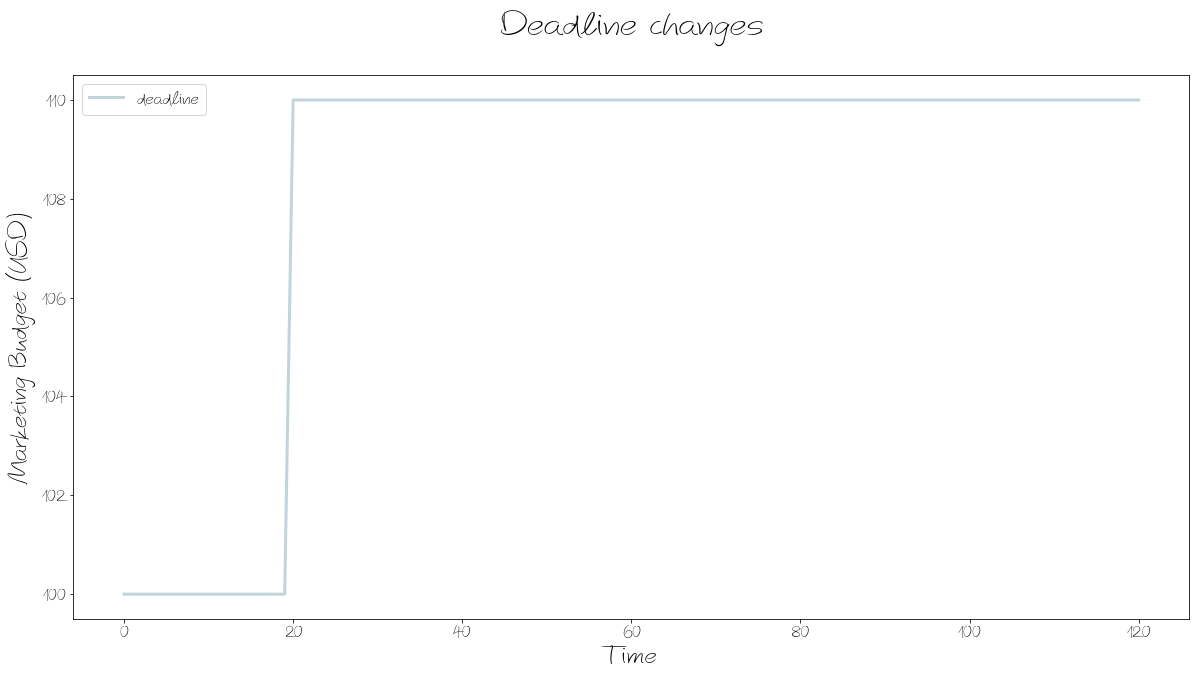

In [9]:
bptk.plot_scenarios(
    scenario_managers=["smSimpleProjectManagement"],
    scenarios=["scenario120"], 
    equations=["deadline"],
    title="Deadline changes\n",
    x_label="Time",
    y_label="Marketing Budget (USD)",
    strategy=True, kind="line"
)


## Advanced: Extended Strategies / Manipulation during runtime
Now it gets really interesting and rather complex. The goal is to replace certain equations of the model with custom lambda functions during runtime. This is for advanced use only and currently considered unstable.

First we need to obtain the scenarios and their corresponding simulation models and replace the given equations with the new lambda. 
An extended strategy is just another dictionary. In general, it looks like this:
```
scenarios = bptk.scenario_manager_factory.get_scenarios(scenario_managers=["smSimpleProjectManagement"])


extended_strategy= {
    "scenario80" : {
        "10" : { 
            "initialOpenTasks" : lambda t :0 if t <= 1 else 42 + scenarios["scenario80"].model.memoize("initialOpenTasks",t-1) ,
        }
    }    
}
```
You see that this concept is rather complex and requires understanding of Python. First we have to load all available scenarios. The dictionary contains *pointers* to the specific scenario objects that we loaded from the scenario files. They are stored in the ``ScenarioManager`` object instance of the ``bptk`` object. The lambda functions now have to use these pointers to receive the pointers to the ``model`` object (and therefore the equations) of the simulation model. 
We will overwrite the specific equations with the given lambda function(s) in the previously-described strategy dictionary of the scenario. It is possible to store lambda functions just like this as strings in JSON **but** the complexity is even higher when it comes to adding it to the model during run-time. As the bptk object uses the same set of scenarios, it will use the same object pointers when we finally issue ``bptk.plot_scenarios(... ,strategy=True)``

We begin with defining the new, extended strategy. It plays a around with the initial open Tasks. It will return 0 if at starttime of the model. Otherwise, it returns the value of t-dt multiplied by 1,000. See also how we get the dt and start time of the model by accessing the scenarios.


In [5]:
from BPTK_Py.bptk import bptk
bptk=bptk()
scenarios = bptk.scenario_manager_factory.get_scenarios(scenario_managers=["smSimpleProjectManagement"])

dt = scenarios["scenario80"].model.dt


extended_strategy= {
    "scenario80" : {
        "10" : { 
            "initialOpenTasks" : lambda t :0 if t <= 1 else 42 + scenarios["scenario80"].model.memoize("initialOpenTasks",t-1) ,
            "deadline" : lambda t : 80
        }
    }    
}

bptk.modify_strategy(scenarios=scenarios,extended_strategy=extended_strategy)



And now we run the method ``bptk.modify_strategy(scenarios,extended_strategy)``. It receives the pointers to the scenarios object and the modifications to the existing strategy. The method will just take the dictionary and fill up the strategy field of the scenario(s) with the lambda function objects.

Please keep in mind that ``bptk`` stores the old lambda function. It runs the simulation until ``t-1``, inserts the new function and continues until the next change. If you want to re-run the scenario with another modified strategy, just flush the ``ScenarioManager``'s ``scenario`` object:
```
bptk.scenario_manager_factory.reset_scenario(scenario_name="scenario80",scenario_manager="smSimpleProjectManagement")
```
This will cause the scenario manager to reload the scenario's simulation model from the source file.
Finally, you may use the plotting methods with the ``strategy=True`` parameter for simulating and plotting the modified scenarios. 

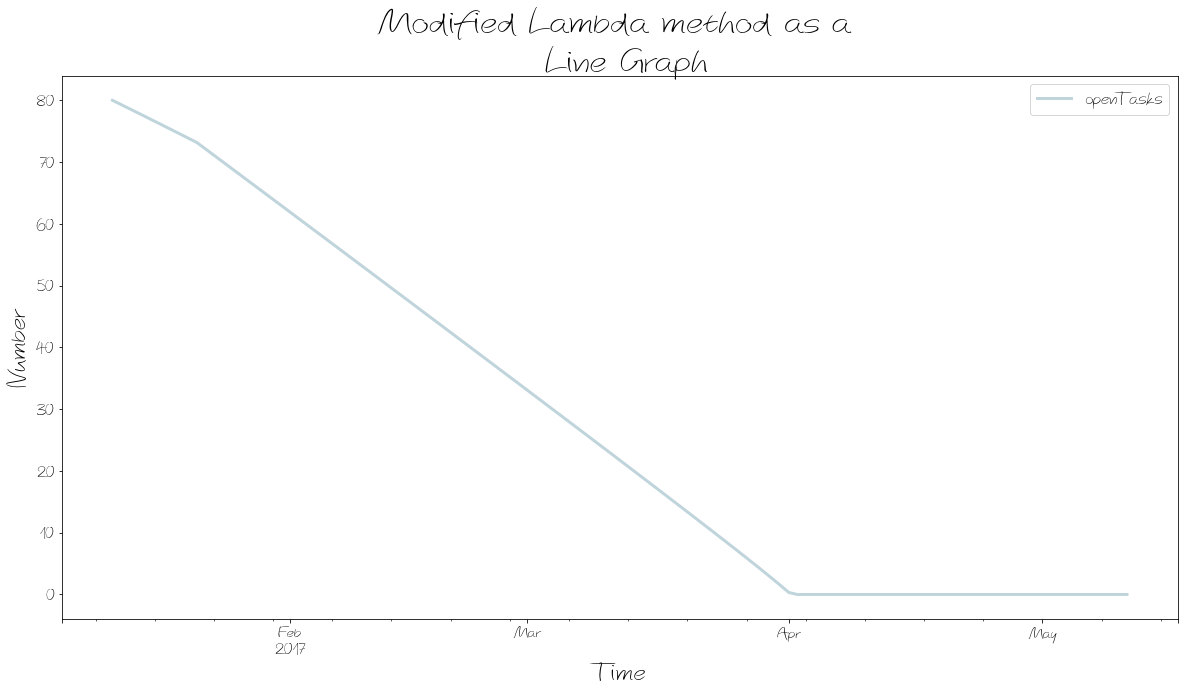

In [9]:
## Plot the graph with the extended stratefy
bptk.plot_scenarios(
    scenario_managers=["smSimpleProjectManagement"],
    scenarios=["scenario80"],
    kind="line",
    equations=["openTasks"],
    stacked=False, 
    strategy=True,
    freq="D", 
    start_date="1/11/2017",
    title="Modified Lambda method as a \n Line Graph",
    x_label="Time",
    y_label="Number"
)

# Create Scenarios during Runtime
It is possible to add scenarios during runtime. For convenience, here is some example code you may use as a template to generate your own scenarios during runtime. If you define multiple scenarios for the same ``scenario_manager``, this is no problem. 

First define the details for the scenario manager and then set up the name of the scenario, the strategy and the constants. The strategy may as well be one of the complex ones as described above. But be careful to define everything correctly.

In [12]:
from BPTK_Py.scenariomanager.scenario import simulationScenario
from BPTK_Py.scenariomanager.scenario_manager import scenarioManager
from BPTK_Py.bptk import bptk
bptk = bptk()
scenario_manager = {
    "name" : "ScenarioManager_temp",
    "model" : "simulation_models/sd_simple_project",
    "source" : "simulation_models/sd_simple_project.itmx"
}


name = "scenario_160"
strategy = {
            "20": {
                "deadline" : 2000
            } 
}
constants = {
            "deadline" : 160,
            "effortPerTask" : 0.1
        }


dictionary ={ scenario_manager["name"]:  
             {
                "model": scenario_manager["model"],
                "source": scenario_manager["source"],
                 name:{
                     "constants" : constants, 
                     "strategy" : strategy
                 } 
             } 
            }


bptk.add_scenario(dictionary=dictionary)



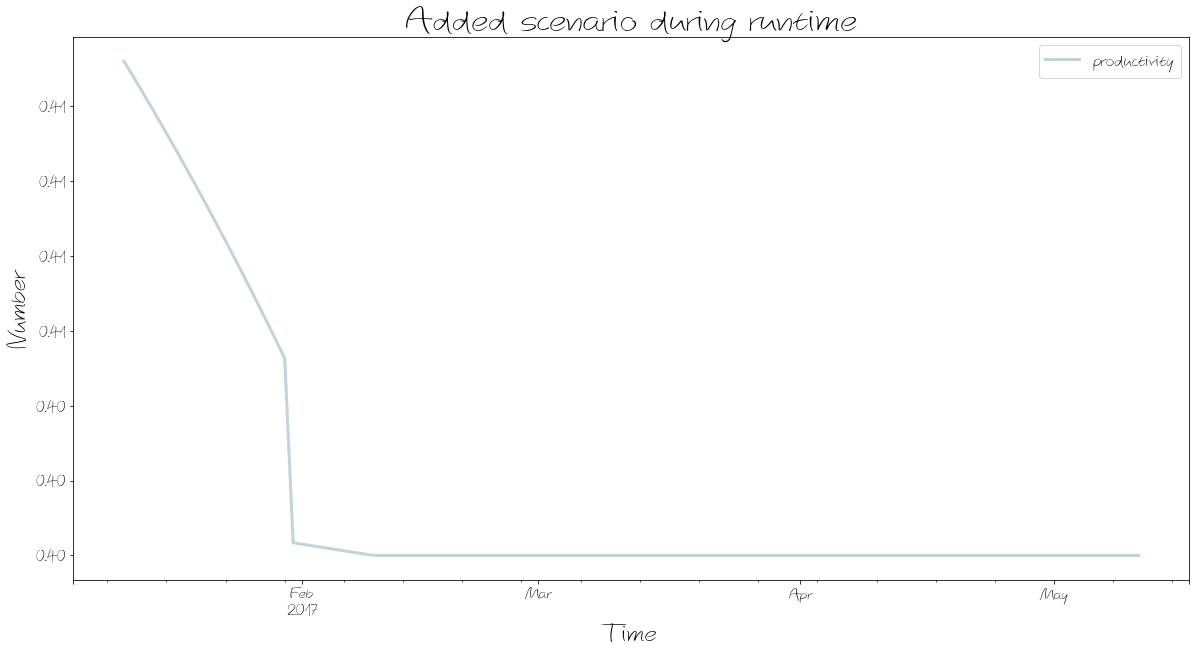

In [13]:
bptk.plot_scenarios(
    scenario_managers=["ScenarioManager_temp"],
    scenarios=["scenario_160"],
    kind="line",
    equations=["productivity"],
    stacked=False, 
    strategy=True,
    freq="D", 
    start_date="1/11/2017",
    title="Added scenario during runtime",
    x_label="Time",
    y_label="Number",
)

## Model Checking
To verify the behavior of the simulator and of the simulation model, it is important to check certain assertions. ``bptk_py`` comes with a simple model checker to verify ``lambda`` functions, small functions stored in a variable.
The function is supposed to only return True or False and receives a data parameter. For example ``lambda data : sum(data)/len(data) < 0`` tests if the average of the data is below 0. We can get the raw output data instead of the plot if we use the parameter ``return_df=True``. This returns a dataFrame object. The following example generates this dataframe and uses the model checker to test if the ``productivity`` series' mean is below 0. Otherwise it will return the specified message.

In [14]:
df =bptk.plot_scenarios(
    scenario_managers=["smSimpleProjectManagement"],
    scenarios=["scenario120"],
    kind="line",
    equations=["productivity"],
    stacked=False, 
    strategy=True,
    freq="D", 
    start_date="1/11/2017",
    title="Added scenario during runtime",
    x_label="Time",
    y_label="Number",
    return_df=True
    )

check_function = lambda data : sum(data)/len(data) < 0

bptk.model_check(df["productivity"],check_function,message="Productivity is not <0")

[ERROR] Model Checking failed with message: "Productivity is not <0"


## Resetting the simulation
After a while of simulating, modifying strategies and constants and generating beautiful plots, you may realize that you want to go back and reset the simulation. For this purpose, you have three methods available:
* ``reset_scenario(scenario_manager, scenario)``: This deletes a specific scenario from memory and reloads it from file. Requires the scenario manager's name and the scenario name.
* ``reset_all_scenarios()``: Reset all scenarios and re-read from file
* ``reset_simulation_model(scenario_manager, scenario="")``: For runtime optimizations, the simulator will cache the simulation results. In some rare cases, this cache may not be flushed upon scenario modification. Hence, this method resets the simulation model's cache.

See the example usages below:


In [18]:
bptk.reset_scenario(scenario_manager="smSimpleProjectManagement",scenario="scenario80")

bptk.reset_all_scenarios()

bptk.reset_simulation_model("smSimpleProjectManagement","scenario80")
